In [29]:
import re
import os, random
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/marek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [5]:
from time import time
global tic
def toc(msg = "Time elapsed"):
    print(f"{msg}: {(time() - tic)*1000} ms")

## Preprocessing data

In [6]:
import chardet
with open('./dataset/sms-spam-collection-dataset/spam.csv', 'br') as file:
    b = file.read(1024*128)
    print(chardet.detect(b))

{'encoding': 'Windows-1252', 'confidence': 0.7265584523333105, 'language': ''}


In [7]:
spam = pd.read_csv('./dataset/sms-spam-collection-dataset/spam.csv', encoding="Windows-1252")  #, dtype="string")
spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
spam.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


### Missing data & simple analysis

In [9]:
# Inspect missing data columns
spam[spam['Unnamed: 2'].notna() | spam['Unnamed: 3'].notna() | spam['Unnamed: 4'].notna()].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [10]:
print('Missing data in v1, v2:', (spam[spam['v1'].isna()].size, spam[spam['v2'].isna()].size))
df = spam.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2':'message'})
df

Missing data in v1, v2: (0, 0)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Text(0.5, 1.0, 'Ham vs spam')

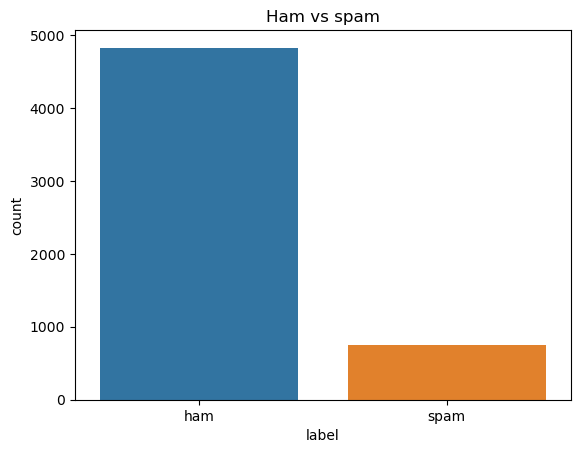

In [11]:
# Count of labeled ham/spam messages
sns.countplot(x=df.label, data=df)
plt.title('Ham vs spam')

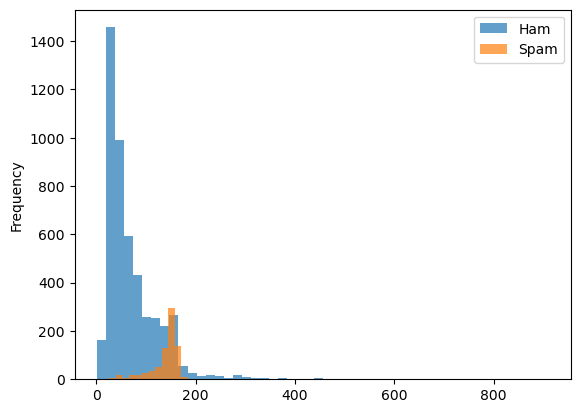

In [12]:
df['message_len'] = df.message.str.len()

df[df.label == 'ham'].message_len.plot(kind='hist', bins=50, alpha=0.7, label='Ham')
df[df.label == 'spam'].message_len.plot(kind='hist', bins=16, alpha=0.7, label='Spam')
plt.legend()
plt.show()

### Clean text data

 * lowercase
 * split by words
 * remove non-alphanumeric characters - both punctuation and badly decoded characters like _å_
 * remove stop-words - most common words like (a, the, he, she) that doesn't provide significant information

In [13]:
# test function using build-in Python methods
example_msg_indexes = [12,4,18]

def clean_text_python(s):
    s = s.lower()
    s = re.sub('[^a-z0-9]', ' ', s) # replacing with a space so that e.g. "I'm" will be split into 2 words
    s = s.strip()
    s = re.split('\s+', s)
    return ' '.join(s)

def test_clean_text(s):
    clean = clean_text_python(s)
    print(f'Original: "{s}"')
    print(f'Clean   : "{clean}"')
    print()
for i in example_msg_indexes:
    test_clean_text(df.iloc[i].message)
tic = time()
df.message.apply(clean_text_python)
toc("apply(clean_text)")

Original: "URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
Clean   : "urgent you have won a 1 week free membership in our 100 000 prize jackpot txt the word claim to no 81010 t c www dbuk net lccltd pobox 4403ldnw1a7rw18"

Original: "Nah I don't think he goes to usf, he lives around here though"
Clean   : "nah i don t think he goes to usf he lives around here though"

Original: "Fine if thatåÕs the way u feel. ThatåÕs the way its gota b"
Clean   : "fine if that s the way u feel that s the way its gota b"

apply(clean_text): 30.20453453063965 ms


In [14]:
eng_stopwords = stopwords.words('english') + ['r', 'u', 'ru', 'ure']
print('Stop-words:', eng_stopwords)

def clean_text_pandas(df: pd.DataFrame):
    df['message_cleaned'] = (
      df.message
        .str.lower()
        .str.replace('[^a-z0-9]', ' ', regex=True)
        .str.strip()
        .str.split('\s+', regex=True)
        .apply(lambda word_list: list(filter(lambda x: x not in eng_stopwords, word_list)))
        .str.join(' ')
    )

tic = time()
clean_text_pandas(df)
toc("clean_text_pandas")

print()
for i in example_msg_indexes:
    print(f'Original: "{df.iloc[i].message}"')
    # print(f'Clean   : "{clean_df.iloc[i].message}"')
    print(f'Clean   : "{df.iloc[i].message_cleaned}"')
    print()

df.label.replace({"spam": 1, "ham": 0}, inplace=True)
df

Stop-words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

,label,message,message_len,message_cleaned
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,2nd time tried 2 contact 750 pound prize 2 cla...
5568,0,Will Ì_ b going to esplanade fr home?,37,b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity mood suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...


### Vectorization

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.message_cleaned, df.label)
print(X_train.shape, X_test.shape)

(4179,) (1393,)


In [16]:
vectorizer = CountVectorizer()
# vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r"\b\w+\b", min_df=1)
# vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Models

 * decission tree
 * SVC
 * logictic regression
 * multinomial Naive Bayess
 * neural network

#### Scikit-learn models

In [17]:
plt.rcParams['figure.figsize'] = [4, 4]

kfold = KFold(n_splits=5)

trained_models = []
_trained_models_columns = ['Model', 'Accuracy', 'Precision', 'Recall']

def train_model(model, params_grid, hidden=False):
    pipe = Pipeline()

    grid = GridSearchCV(model, params_grid, cv=kfold, refit=True, return_train_score=True)

    %time grid.fit(X_train_vectorized, y_train)

    y_pred = grid.predict(X_test_vectorized)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    print("\nAccuracy:", acc)
    print("Best score:", grid.best_score_)

    if not hidden:
        trained_models.append([grid.best_estimator_, acc, precision, recall])

        cm = metrics.confusion_matrix(y_test, y_pred)
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.show()
    
    return grid.best_estimator_

def train_simple(model):
    %time model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)
    print("\nAccuracy:", metrics.accuracy_score(y_test, y_pred))
    return model

def get_trained_models_df():
    return pd.DataFrame(data=trained_models, columns=_trained_models_columns)

**Decision tree:**

CPU times: user 4.92 s, sys: 605 µs, total: 4.92 s
Wall time: 4.96 s

Accuracy: 0.9641062455132807
Best score: 0.9693693951809301


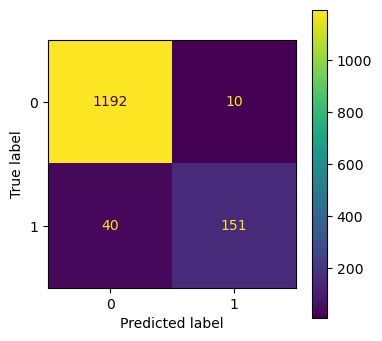

Tree depth: 30


In [18]:
from sklearn.tree import DecisionTreeClassifier

tree = train_model(DecisionTreeClassifier(), {
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [None] + list(range(5, 50, 5)),
})
print("Tree depth:", tree.get_depth())

**Support vector clustering (SVC):**

In [19]:
from sklearn.svm import SVC

train_model(SVC(), {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
}, hidden=True)

CPU times: user 9.1 s, sys: 104 ms, total: 9.21 s
Wall time: 9.22 s

Accuracy: 0.9791816223977028
Best score: 0.983727473283099


SVC(kernel='linear')

CPU times: user 6.71 s, sys: 1.06 ms, total: 6.71 s
Wall time: 6.73 s

Accuracy: 0.9791816223977028
Best score: 0.983727473283099


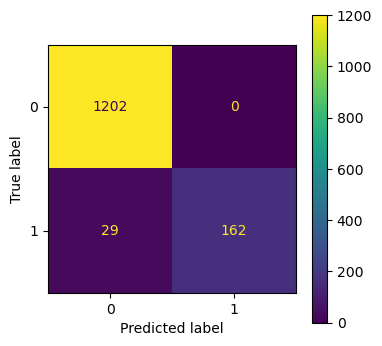

SVC(C=1, kernel='linear')

In [20]:
train_model(SVC(kernel="linear"), {
    "C": [0.01, 0.1, 1, 2, 5, 10],
})

**Logistic regression:**

CPU times: user 917 ms, sys: 39.9 ms, total: 957 ms
Wall time: 914 ms

Accuracy: 0.9777458722182341
Best score: 0.9832490043835774


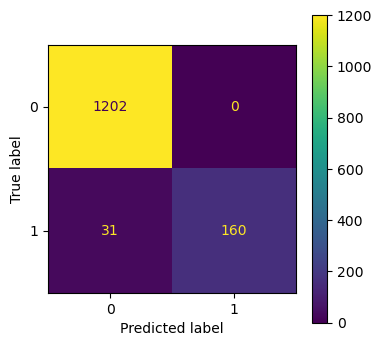

LogisticRegression(C=10000, solver='liblinear')

In [21]:
from sklearn.linear_model import LogisticRegression

# train_simple(LogisticRegression())
train_model(LogisticRegression(solver="liblinear"), {
    "penalty": ['l1', 'l2'],
    "C": list(map(lambda x: 10**x, range(-2,10))),
})

**Multinomial Naive Bayess:**

CPU times: user 113 ms, sys: 31.9 ms, total: 145 ms
Wall time: 102 ms

Accuracy: 0.9798994974874372
Best score: 0.9856416353895081


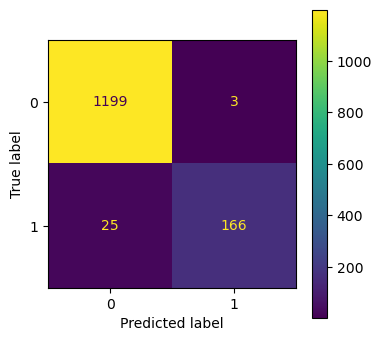

MultinomialNB(alpha=4)

In [22]:
from sklearn.naive_bayes import MultinomialNB

train_model(MultinomialNB(), {
    "alpha": range(1,10),
})

#### Neural networks:

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPool2D, MaxPooling1D, GlobalMaxPooling1D, GlobalMaxPooling2D, Embedding
from keras.callbacks import EarlyStopping, History
# from keras.metrics import Accuracy, Recall, Precision
import keras.metrics

def train_keras_model(model, name = 'Neural network'):
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    %time history = model.fit(X_train_vectorized.toarray(), y_train, epochs=20, callbacks=[early_stopping])
    ev = model.evaluate(X_test_vectorized.toarray(), y_test)
    print(ev)
    loss, acc, recall, precision = model.evaluate(X_test_vectorized.toarray(), y_test)
    trained_models.append([name, acc, precision, recall])

**Simple network:**

In [24]:
keras.backend.clear_session()
print([X_train_vectorized.shape, y_train.shape])

n_features = X_train_vectorized.shape[1]

model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(n_features,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        'accuracy',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
    ],
)

model.summary()

[(4179, 7260), (4179,)]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                464704    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 473,153
Trainable params: 473,153
Non-trainable params: 0
_________________________________________________________________


In [25]:
train_keras_model(model, 'Simple neural network')

Epoch 1/20
131/131 [==============================] - 1s 2ms/step - loss: 0.2390 - accuracy: 0.9273 - recall: 0.4784 - precision: 0.9500
Epoch 2/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9947 - recall: 0.9712 - precision: 0.9890
Epoch 3/20
131/131 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9995 - recall: 0.9982 - precision: 0.9982
Epoch 4/20
131/131 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 0.9998 - recall: 0.9982 - precision: 1.0000
Epoch 5/20
131/131 [==============================] - 0s 1ms/step - loss: 6.5971e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 6/20
131/131 [==============================] - 0s 1ms/step - loss: 3.6088e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 7/20
131/131 [==============================] - 0s 1ms/step - loss: 2.3719e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 8/20
131/131 [=========

**Network with added batch normalization & dropout:**

In [26]:
keras.backend.clear_session()
print([X_train_vectorized.shape, y_train.shape])

n_features = X_train_vectorized.shape[1]

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        'accuracy',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
    ],
)

model.summary()

[(4179, 7260), (4179,)]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                464704    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (No

In [27]:
train_keras_model(model, 'Neural network w/batch normalization')

Epoch 1/20
131/131 [==============================] - 1s 2ms/step - loss: 0.2628 - accuracy: 0.9036 - recall: 0.9137 - precision: 0.5886
Epoch 2/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.9868 - recall: 0.9622 - precision: 0.9402
Epoch 3/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9940 - recall: 0.9748 - precision: 0.9801
Epoch 4/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9919 - recall: 0.9874 - precision: 0.9531
Epoch 5/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9978 - recall: 0.9910 - precision: 0.9928
Epoch 6/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9983 - recall: 0.9946 - precision: 0.9928
Epoch 7/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9976 - recall: 0.9964 - precision: 0.9858
Epoch 8/20
131/131 [=====================

### Summary

#### Comparing models:

In [28]:
get_trained_models_df().sort_values(by="Accuracy", ascending=False)

,Model,Accuracy,Precision,Recall,F1 score
5,Neural network w/batch normalization,0.982053,1.000000,0.869110,NaN
4,Simple neural network,0.979900,1.000000,0.853403,NaN
3,MultinomialNB(alpha=4),0.979899,0.982249,0.869110,0.922222
1,"SVC(C=1, kernel='linear')",0.979182,1.000000,0.848168,0.917847
2,"LogisticRegression(C=10000, solver='liblinear')",0.977746,1.000000,0.837696,0.911681
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.964106,0.937888,0.790576,0.857955
